In [1]:
import wandb
wandb.init(project='Vae-test')

W&B Run: https://app.wandb.ai/evs/Vae-test/runs/a9vectsn

In [36]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
from sklearn.decomposition import PCA
import tqdm.notebook as tqdm

In [40]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7, 5, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)




### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [41]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 28**2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=64, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs



Following we define the PyTorch functions for training and evaluation.

In [42]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()

Test the forward pass, to check that everything is in order.

In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

In [43]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.train()
    
    # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 20:
          break
        # Load the input features and labels from the training dataset
        x, y = data.to(device), target.to(device)

        # Reset the gradients to 0 for all learnable weight parameters
        optimizer.zero_grad()
        
        # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
        outputs = model(x)
        
        # Define our loss function, and compute the loss
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        #print(x_hat.shape, x.shape, mu.shape, log_var.shape)

        elbo, kl = loss_function(x_hat, x, mu, log_var)        
        # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
        elbo.backward()
        
        # Update the neural network weights
        optimizer.step()
        
        wandb.log({
        "Train elbo": elbo.item(),
        "Train KL": kl.item()
        })

In [72]:
def test(args, model, device, test_loader, classes):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    example_images = []
    with torch.no_grad():
        data, target = next(iter(test_loader))
        # Load the input features and labels from the test dataset
        x, y = data.to(device), target.to(device)

        # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
        outputs = model(x)

        # Compute the loss sum up batch loss
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
        #visualize latent space
        rows = 8
        columns = args.batch_size // rows
        plt.title('Latent space')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        span = np.linspace(-4, 4, rows)
        grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)

        # If you want to use a dimensionality reduction method you can use
        # for example PCA by projecting on two principal dimensions
        z = PCA(n_components=2).fit_transform(np.mean(z, axis=1))

        colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
        for c in classes:
            plt.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
        show_sampling_points=True
        if show_sampling_points:
            plt.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")




    # WandB – wandb.log(a_dict) logs the keys and values of the dictionary passed in and associates the values with a step.
    # You can log anything by passing it to wandb.log, including histograms, custom matplotlib objects, images, video, text, tables, html, pointclouds and other 3D objects.
    # Here we use it to log test accuracy, loss and some test images (along with their true and predicted labels).
    wandb.log({
        "Latent Space": plt,
        "Test elbo": elbo.item(),
        "Test KL": kl.item()
        })

In [45]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 64          # input batch size for training (default: 64)
config.test_batch_size = 10    # input batch size for testing (default: 1000)
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 0.1               # learning rate (default: 0.01)
config.momentum = 0.1          # SGD momentum (default: 0.5) 
config.no_cuda = False         # disables CUDA training
config.seed = 42               # random seed (default: 42)
config.log_interval = 10     # how many batches to wait before logging training status

In [73]:
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Set random seeds and deterministic pytorch for reproducibility
# random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed) # pytorch random seed
# numpy.random.seed(config.seed) # numpy random seed
torch.backends.cudnn.deterministic = False


In [74]:

latent_features = 10
num_samples = 10

# Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
model = VariationalAutoencoder(latent_features, num_samples).to(device)

optimizer = optim.SGD(model.parameters(), lr=config.lr,
                      momentum=config.momentum)

loss_function = ELBO_loss
wandb.watch(model, log="all")


/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning:

train_labels has been renamed targets

/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning:

test_labels has been renamed targets



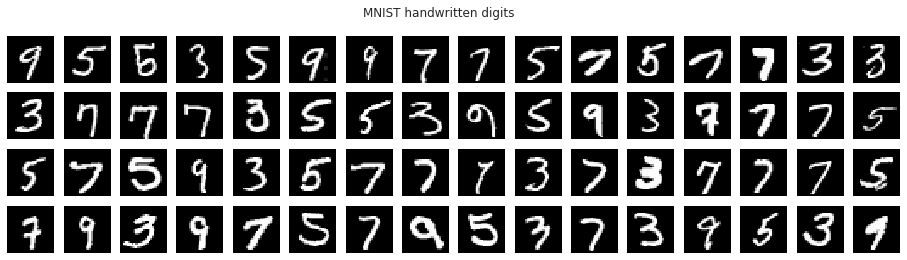

In [48]:
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=config.batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=config.batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda)

#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

In [75]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)

if cuda:
    x = x.cuda()

outputs = model(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 10, 10])
tensor(542.4717, grad_fn=<NegBackward>)
tensor(2.8835, grad_fn=<SumBackward0>)


In [76]:
for epoch in tqdm.tqdm(range(1, config.epochs + 1)):
    train(config, model, device, train_loader, optimizer, epoch)
    test(config, model, device, test_loader, classes)

# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
torch.save(model.state_dict(), "model.h5")
wandb.save('model.h5')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



['/home/evangelos/workspace/Channel_Charting/notebooks/wandb/run-20200201_144258-a9vectsn/model.h5']